### Introduction to Machine Learning in Finance and Insurance (Spring 2024)
# Project 2: Insurance Claim Prediction

### Team members: LastName1 FirstName1, LastName2 FirstName2, LastName3 FirstName3

In [81]:
### Import all the Python libraries you are going to use
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [82]:
### Fix random seed for reproducibility
sed_val = 10
np.random.seed(sed_val)

# Exercise 1. Poisson GLM.

In [83]:
# Read csv file
# You can use pandas (see the notebook "Project 2 - Insurance Claim Prediction - Sandbox")
mtpl_freq_df = pd.read_csv('freMTPL2freq.csv',
                           sep=';',
                           decimal=',')

In [84]:
mtpl_freq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678007 entries, 0 to 678006
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   VehPower    678007 non-null  int64  
 1   VehAge      678007 non-null  int64  
 2   DrivAge     678007 non-null  int64  
 3   BonusMalus  678007 non-null  int64  
 4   VehBrand    678007 non-null  object 
 5   VehGas      678007 non-null  object 
 6   Density     678007 non-null  int64  
 7   Region      678007 non-null  object 
 8   Exposure    678007 non-null  float64
 9   ClaimNb     678007 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 51.7+ MB


* there are 5 numerical features and 3 categorical features

In [85]:
# Check that exposure is always positive
all(mtpl_freq_df.Exposure > 0)

True

In [86]:
# Add frequency to the data
mtpl_freq_df['Freq'] = mtpl_freq_df.ClaimNb / mtpl_freq_df.Exposure
mtpl_num_features = mtpl_freq_df.describe().columns
mtpl_freq_df.describe()

,VehPower,VehAge,DrivAge,BonusMalus,Density,Exposure,ClaimNb,Freq
count,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000
mean,6.454653,7.044218,45.499061,59.761588,1792.430975,0.528547,0.038913,0.117907
std,2.050902,5.666235,14.137492,15.636700,3958.663031,0.364081,0.204752,2.002881
min,4.000000,0.000000,18.000000,50.000000,1.000000,0.002732,0.000000,0.000000
25%,5.000000,2.000000,34.000000,50.000000,92.000000,0.180000,0.000000,0.000000
50%,6.000000,6.000000,44.000000,50.000000,393.000000,0.490000,0.000000,0.000000
75%,7.000000,11.000000,55.000000,64.000000,1658.000000,0.990000,0.000000,0.000000
max,15.000000,100.000000,100.000000,230.000000,27000.000000,1.000000,5.000000,365.000000


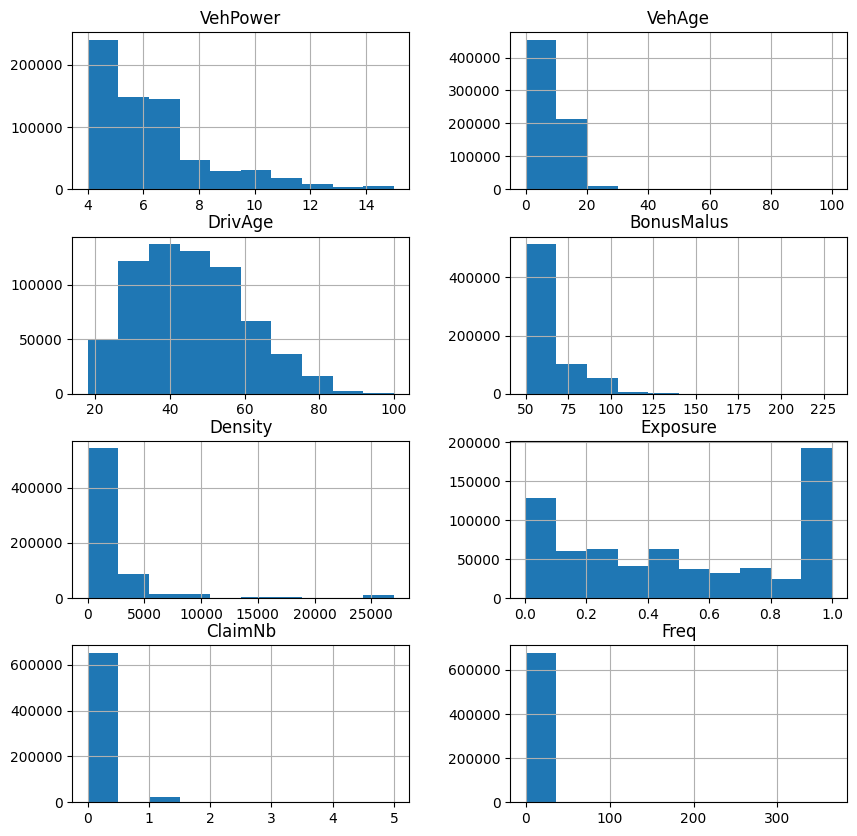

In [87]:
# Lets have a look at the distributions of the numerical features
mtpl_base_feautures, mtpl_response = mtpl_freq_df.columns[:-3], mtpl_freq_df.columns[-3:]
mtpl_freq_df.hist(layout=(4,2), figsize=(10,10))
plt.show()

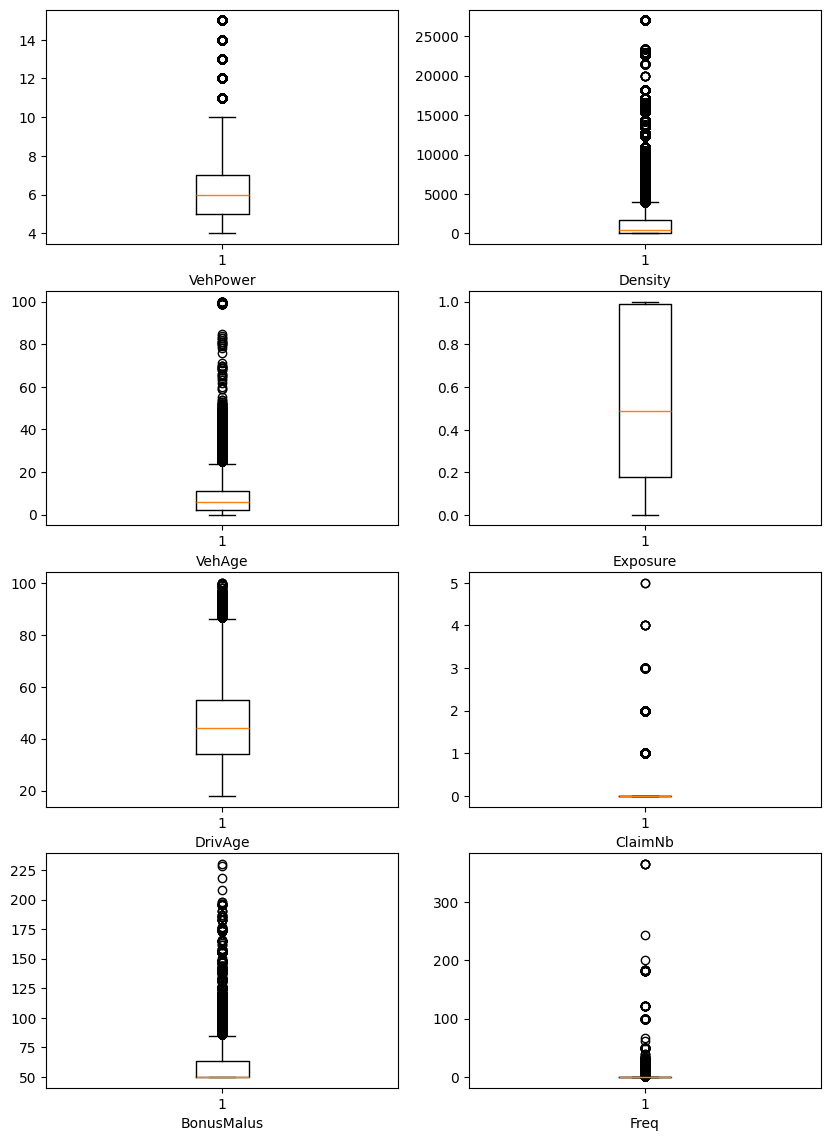

In [88]:
fig, axs = plt.subplots(4, 2, figsize=(10, 14))
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].boxplot(mtpl_num_features[(i)+j*axs.shape[0]],data=mtpl_freq_df)
        axs[i,j].set_xlabel(mtpl_num_features[(i)+j*axs.shape[0]])
plt.show()

Many features are skewed and we could benefit from preprocessing

In [89]:
# Add extra engineered features to the dataset
mtpl_freq_df['DrivAge2'] = np.power(mtpl_freq_df['DrivAge'],2)
mtpl_freq_df['BonusM_DriveAge'] = mtpl_freq_df['BonusMalus'] * mtpl_freq_df['DrivAge']
mtpl_freq_df['BonusM_DrivAge2'] = mtpl_freq_df['BonusMalus'] * mtpl_freq_df['DrivAge2']

mtpl_engineered_feautures = ['DrivAge2', 'BonusM_DriveAge', 'BonusM_DrivAge2']
mtpl_features = mtpl_base_feautures.tolist() + mtpl_engineered_feautures

### Test train split

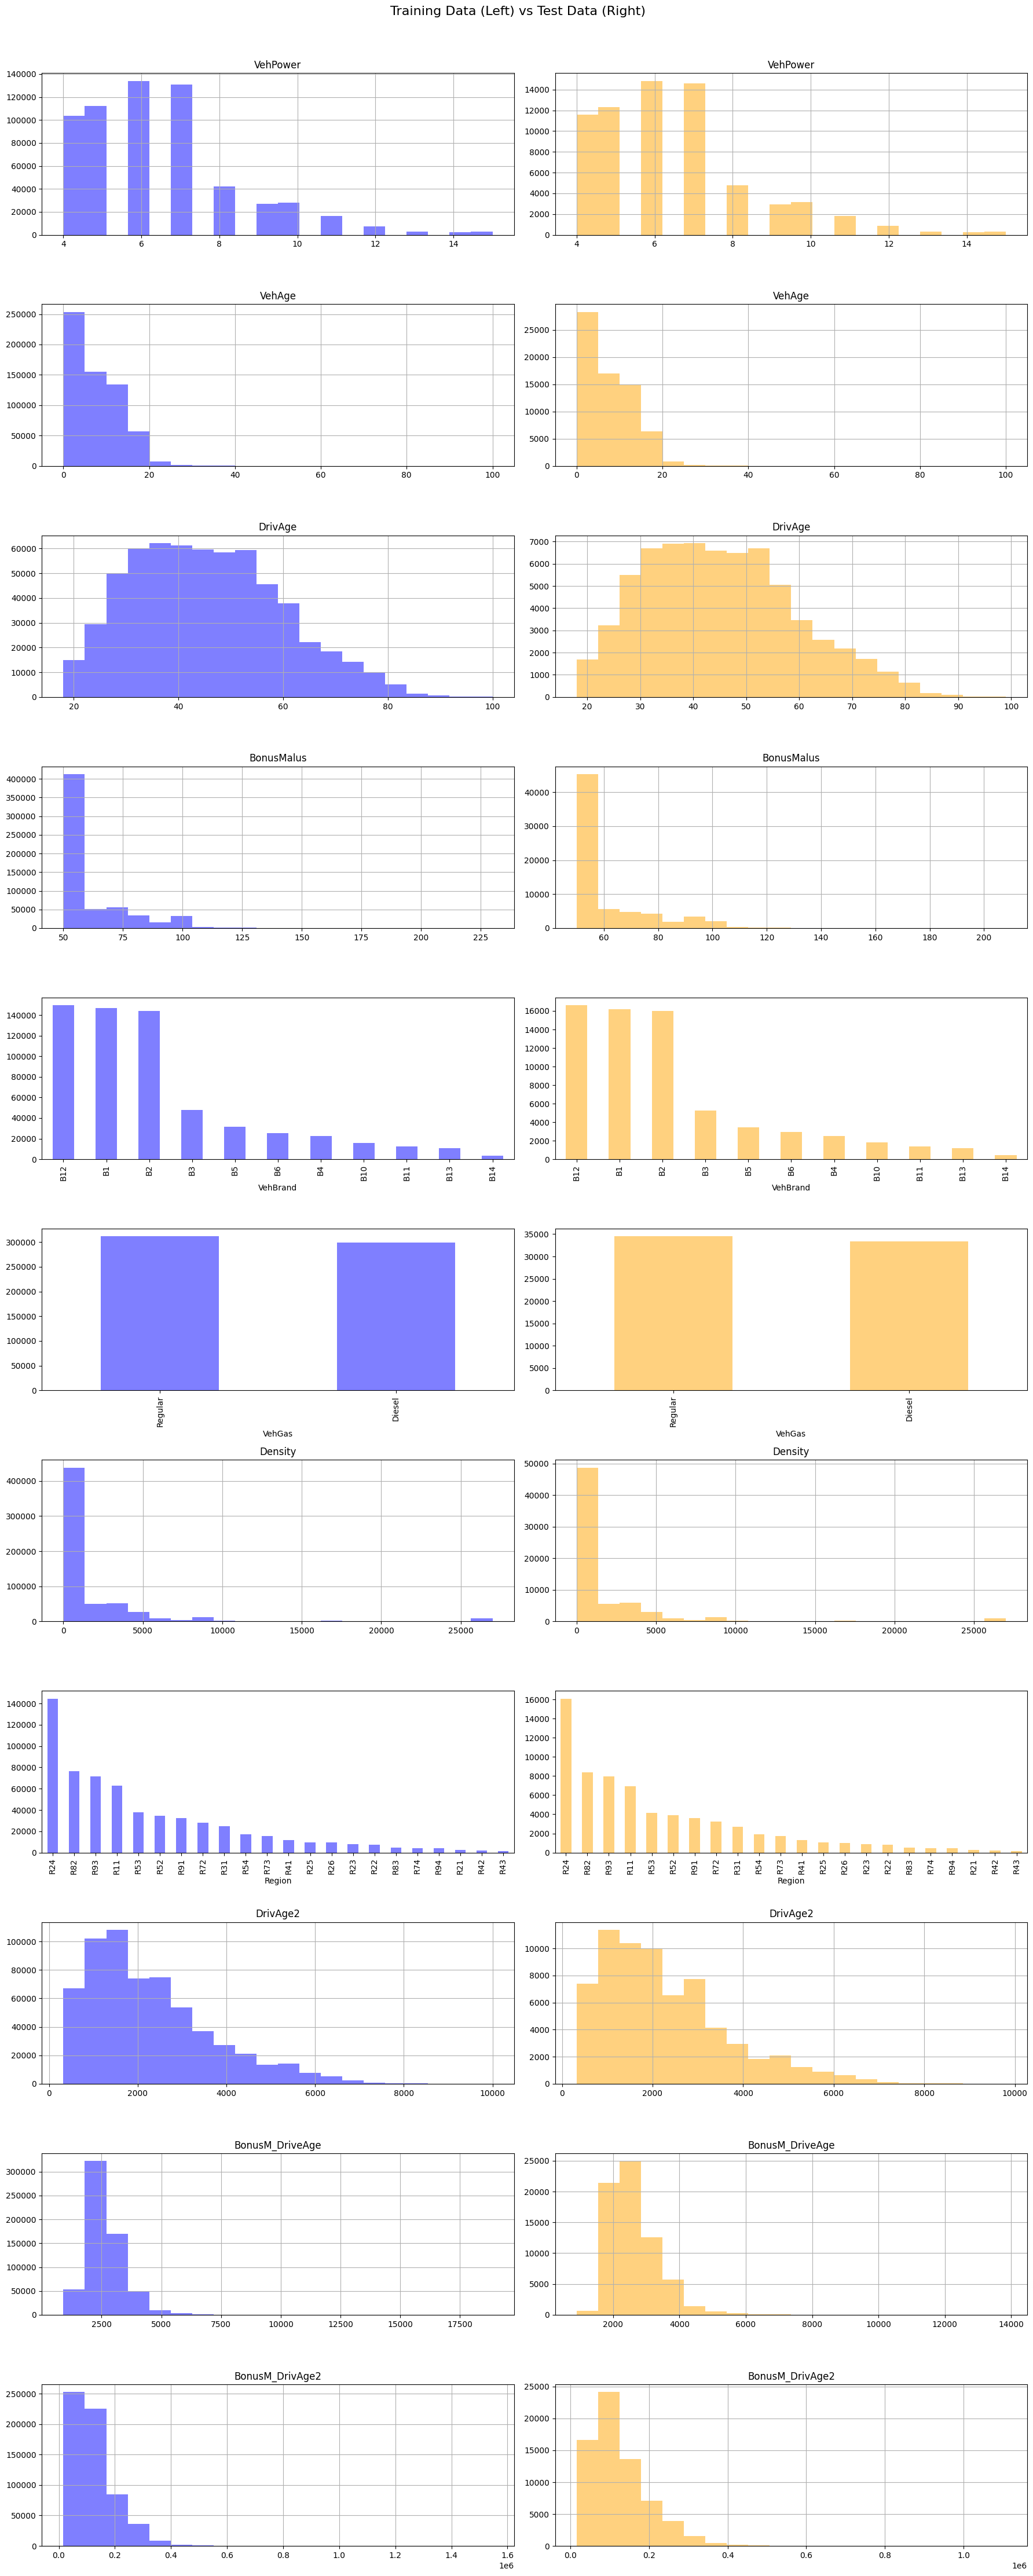

In [90]:
from sklearn.model_selection import train_test_split

X = mtpl_freq_df[mtpl_features]
y = mtpl_freq_df[mtpl_response]

# Train, validation and test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=sed_val)

# Compare daata before and after the split
num_plots = len(mtpl_features)
fig, axs = plt.subplots(nrows=num_plots, ncols=2, figsize=(18,num_plots*4))

for idx, feature in enumerate(mtpl_features):
        if X_train[feature].dtype == 'object':
            X_train[feature].value_counts().plot(kind='bar', color='blue', ax=axs[idx, 0], alpha=0.5)
            X_test[feature].value_counts().plot(kind='bar', color='orange', ax=axs[idx, 1], alpha=0.5)
        else:
            X_train.hist(feature, bins=20, alpha=0.5, label='Training Set', color='blue', ax=axs[idx, 0])
            X_test.hist(feature, bins=20, alpha=0.5, label='Test Set', color='orange', ax=axs[idx, 1])


plt.suptitle("Training Data (Left) vs Test Data (Right)", fontsize=16, y=1.01)
plt.subplots_adjust(top=0.2) 
plt.tight_layout()

plt.show()

Visually the distributions of train and test data looks similar

### Preprocessing pipeline

In [91]:
from sklearn.base import TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from matplotlib.ticker import FuncFormatter, MaxNLocator

class CustomBinner(TransformerMixin):
    def __init__(self, bins, labels):
        self.bins = bins
        self.labels = labels

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = pd.cut(X.iloc[:, 0], bins=self.bins, labels=self.labels)
        return X.values.reshape(-1, 1)

#### Log transformation and binning 

In [92]:
# Pre-process features
def create_transformer(num_features, bin_features, one_hot_features, engineered_feauters):
        def gen_transformer(kind: str = 'full'):#, num_features=num_features, bin_features=bin_features, one_hot_features=one_hot_features, engineered_feauters=engineered_feauters):
                """returns transformer dependend on the usecase

                Args:
                kind (str): test - only log transform and normalise,
                            base - log transform, normalise and one-hot encodeing
                                        but without engineered features
                            full - all features included
                            nn - one_hot encoding of categorical features
                """
                bins = [-np.inf, 5, 12, np.inf]
                labels = ['car_0_6', 'car_6_13', 'car_13+']
                local_num_features = num_features
                
                bin_transformer = make_pipeline(CustomBinner(bins, labels))
                
                log_transformer = make_pipeline(FunctionTransformer(np.log, validate=True),
                                                StandardScaler())
                if kind == 'nn':
                        one_hot_transformer_GLM = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
                else:
                        one_hot_transformer_GLM = make_pipeline(OneHotEncoder(handle_unknown='ignore', drop='first'))


                if kind != 'full':
                        local_num_features = list(set(local_num_features)
                                            - set(engineered_feauters))
                
                # Remove features that will be turned into categorical variable
                if kind != 'nn':
                        local_num_features = list(set(local_num_features)
                                                - set(bin_features))
                
                if kind == 'test':
                        preprocessor = make_column_transformer(
                                (log_transformer, local_num_features),
                                (bin_transformer, bin_features),
                                remainder='drop'
                        )
                        columns = local_num_features + bin_features
                elif kind == 'nn':
                        preprocessor = make_column_transformer(
                                ('passthrough', local_num_features),
                                (one_hot_transformer_GLM, one_hot_features),
                                remainder='drop'
                        )
                        columns = local_num_features + one_hot_features
                else:   
                        bin_transformer = make_pipeline(
                                        *bin_transformer,
                                        one_hot_transformer_GLM)
                        
                        preprocessor = make_column_transformer(
                                (log_transformer, local_num_features),
                                (bin_transformer, bin_features),
                                (one_hot_transformer_GLM, one_hot_features),
                                remainder='drop'
                        )
                        columns = local_num_features + bin_features + one_hot_features
                print(local_num_features)
                return preprocessor, columns
        return gen_transformer

one_hot_features = mtpl_freq_df.select_dtypes(include=['object']).columns.tolist()
bin_features = ['VehAge']

preproc = create_transformer(X_test.describe().columns.tolist(),
                             bin_features,
                             one_hot_features,
                             mtpl_engineered_feautures)

#### Impact of feature transformations

In [93]:
preprocessor, columns = preproc('test')
preprocessor.fit_transform(X_train)
X_train_log_bin = pd.DataFrame(preprocessor.fit_transform(X_train), columns=columns)
X_train_log_bin = X_train_log_bin.convert_dtypes(infer_objects=True)

['VehPower', 'DrivAge', 'BonusMalus', 'Density']


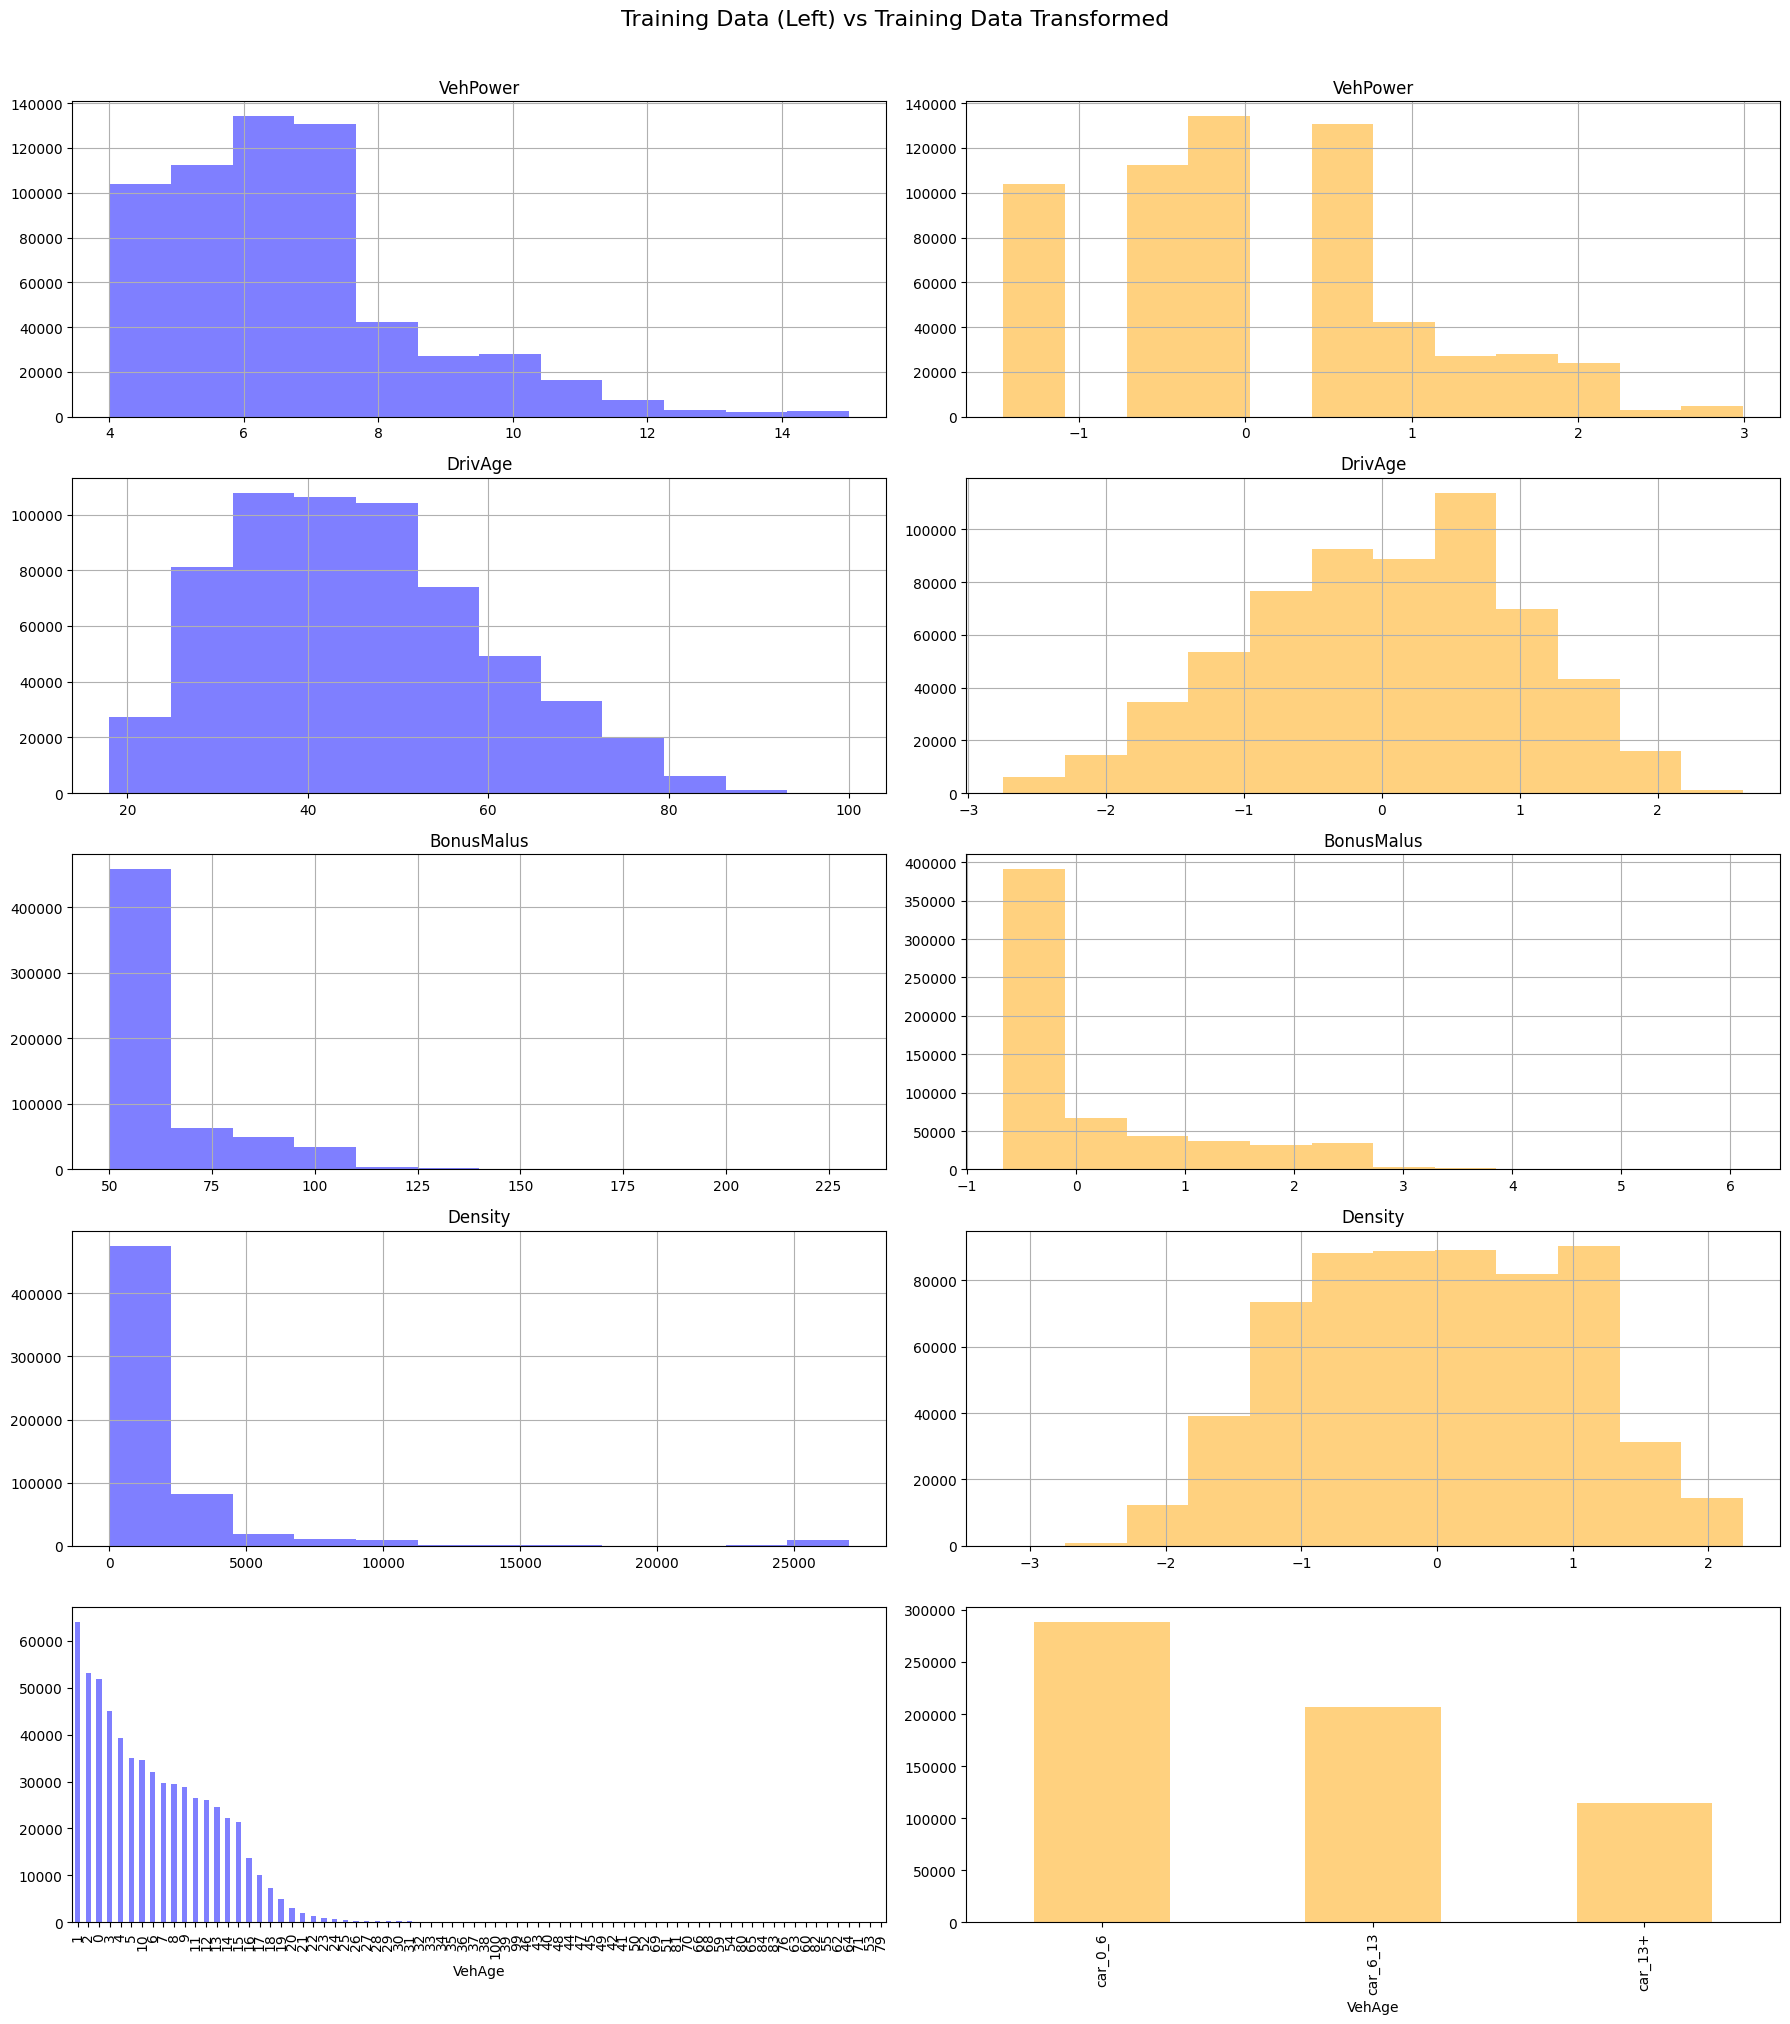

In [94]:
# Define a custom formatter function to format ticks
def format_ticks(value, _):
    return '{:.1f}'.format(value)  # Formats to 2 decimal points

num_plots = len(columns)
fig, axs = plt.subplots(nrows=num_plots, ncols=2, figsize=(18,num_plots*4))

for idx, feature in enumerate(columns):
        if X_train_log_bin[feature].dtype == 'string':
            X_train[feature].value_counts().plot(kind='bar', color='blue', ax=axs[idx, 0], alpha=0.5)
            X_train_log_bin[feature].value_counts().plot(kind='bar', color='orange', ax=axs[idx, 1], alpha=0.5)
        else:
            X_train.hist(feature, alpha=0.5, color='blue', ax=axs[idx, 0], bins=12)
            X_train_log_bin.hist(feature, alpha=0.5, color='orange', ax=axs[idx, 1], bins=12)

plt.suptitle("Training Data (Left) vs Training Data Transformed", fontsize=16, y=1.01)
plt.subplots_adjust(top=0.2) 
plt.tight_layout()

plt.show()

In [95]:
from sklearn.dummy import DummyRegressor

preprocessor, columns = preproc('base')
preprocessor_full, coluns_full = preproc('full')

dummy = Pipeline([
    ('preproc', preprocessor),
    ('regressor', DummyRegressor(strategy='mean'))
]).fit(X_train, y_train['Freq'], regressor__sample_weight=y_train["Exposure"])

['VehPower', 'DrivAge', 'BonusMalus', 'Density']
['BonusMalus', 'VehPower', 'BonusM_DriveAge', 'DrivAge2', 'DrivAge', 'BonusM_DrivAge2', 'Density']


In [96]:
from sklearn.linear_model import PoissonRegressor

poi_glm_base = Pipeline([
    ('preproc', preprocessor),
    ('regressor', PoissonRegressor(alpha=1e-12, solver="newton-cholesky"))
]).fit(X_train, y_train['Freq'], regressor__sample_weight=y_train["Exposure"])

poi_glm_full = Pipeline([
    ('preproc', preprocessor_full),
    ('regressor', PoissonRegressor(alpha=1e-12, solver="newton-cholesky"))
]).fit(X_train, y_train['Freq'], regressor__sample_weight=y_train["Exposure"])


In [97]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_poisson_deviance,
    mean_squared_error,
)
y_pred_dummy = dummy.predict(X_test)
y_pred_glm_base = poi_glm_base.predict(X_test)
y_pred_glm_full = poi_glm_full.predict(X_test)
print(
    mean_poisson_deviance(y_test['Freq'], y_pred_dummy, sample_weight=y_test['Exposure']),
    mean_poisson_deviance(y_test['Freq'], y_pred_glm_base, sample_weight=y_test['Exposure']),
    mean_poisson_deviance(y_test['Freq'], y_pred_glm_full, sample_weight=y_test['Exposure']),
    sep='\n')

0.47106635809588127
0.45059422643616065
0.450594226436174


Results from base and full are strangely close to eachother...

In [98]:
# TODO: Add part about interpretability of the models
# TODO: Add MAE and MSE what do those metrics tell us in this case
# TODO: collect all relevant model metrics into the dataframe
# TODO: Evaluation of the calibration of predictions
# TODO: Evaluation of the ranking power
# TODO: Shap values

In [99]:

# Print MAE, MSE and loss on train and test data sets


# Exercise 2. Poisson feedforward neural network.

In [107]:
# Implement and train a neural network model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from keras_tuner import Objective
from tensorflow.keras.layers import Dense, BatchNormalization, Input
from keras.regularizers import l2

# Random search parameter names
name_kern_regular_layer = 'kernel_regularizer_layer'
name_neuron_count_layer = 'neuron_count_layer'
name_learning_rate = 'learning_rate'
name_activation_function = 'activation_function'
name_elu_param = 'elu_a'
name_num_hidden_layers = 'hidden_layers'

# Set input layer size
preprocessor_nn, columns_nn = preproc('nn')

X_train_nn = preprocessor_nn.fit_transform(X_train)
input_layer_size = X_train_nn.shape[1]

# You can use Keras (see the notebook "Project 2 - Insurance Claim Prediction - Sandbox")
def build_model(hp):
    """
    Build fully connected feed forward neural network models using 
    RandomSearch for some of the parameters.
    """

    model = keras.Sequential()

    # Set network level hp
    hp_activation = hp.Choice(f'{name_activation_function}', ['relu', 'tanh', 'elu'])
    hp_learning_rate = hp.Choice(name_learning_rate, values=[0.0001, 0.0025, 0.00001])
    if hp_activation == 'elu':
        hp_elu_param = hp.Choice(f'{name_elu_param}', values=[0.1,0.5,1.0,1.3])    
    

    model.add(Input(shape=(input_layer_size,)))
    model.add(Dense(42,activation=hp_activation, input_shape=(input_layer_size,) ))   

    for i in range(3,hp.Int(f'{name_num_hidden_layers}', min_value=2, max_value=14, step=2)):
        # Set layer hyperparameters
        hp_neuron_count_layer = hp.Int(f'{name_neuron_count_layer}_{i}', min_value=20, max_value=100, step=20)
        hp_kernel_regularizer_layer = hp.Choice(f'{name_kern_regular_layer}_{i}', values=[0.01, 0.001, 0.001])

        # Add network layers, transform and normalise
        model.add(Dense(units=hp_neuron_count_layer, kernel_regularizer=l2(hp_kernel_regularizer_layer)))
        if hp_activation == 'elu':
            model.add(layers.ELU(alpha=hp_elu_param))
        else:
            model.add(layers.Activation(hp_activation))
        
        model.add(BatchNormalization())

    # Output layer
    model.add(Dense(units=1, activation='exponential'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.Poisson(),
                  metrics=[keras.losses.Poisson(), 'mse', 'mae'])
    return model
    

['BonusMalus', 'VehPower', 'VehAge', 'DrivAge', 'Density']


In [108]:
from tensorflow.keras.callbacks import EarlyStopping

def search_and_train_randomsearch_nn():
    """
    Executes a random search for the best hyperparameters using the buld_model function defined above.
    Once finished, it trains a NeuralNetwork with the found hyperparameters and returns it.
    """

    # Initialize RandomSearch on dataset 1
    tuner = RandomSearch(
        build_model,
        objective=Objective('val_accuracy', 'max'),
        max_trials=1,
        executions_per_trial=1,
        directory='hp_random_search',
        project_name=f'fr_mtpl_frequency',
    )

    # Search for best hyper parameters
    tuner.search(X_train_nn, y_train['Freq'], epochs=40, validation_split=0.1)

    # Initialize a Neural network with this hyperparameters
    best_hp = tuner.get_best_hyperparameters()[0].values
    hp_model = keras.Sequential()
    
    best_activatoin = best_hp[f'{name_activation_function}']
    if best_activatoin == 'elu':
        best_elu_param = best_hp[f'{name_elu_param}']

    hp_model.add(Input(shape=(input_layer_size,)))

    for i in range(3,best_hp[f'{name_num_hidden_layers}']):
        # Set layer hyperparameters
        hp_neuron_count_layer = best_hp[f'{name_neuron_count_layer}_{i}']
        hp_kernel_regularizer_layer = best_hp[f'{name_kern_regular_layer}_{i}']

        # Add network layers, transform and normalise
        hp_model.add(Dense(units=hp_neuron_count_layer, kernel_regularizer=l2(hp_kernel_regularizer_layer)))
        if best_activatoin == 'elu':
            hp_model.add(layers.ELU(alpha=best_elu_param))
        else:
            hp_model.add(layers.Activation(best_activatoin))
        
        hp_model.add(BatchNormalization())
    
    hp_model.add(Dense(units=1, activation='exponential'))
    hp_model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_hp[name_learning_rate]),
                  loss=keras.losses.Poisson(),
                  metrics=[keras.losses.Poisson(), 'mse', 'mae'])        

    # Define early stoping conditions and train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    hp_model.fit(x=X_train_nn, y=y_train['Freq'], validation_split=0.2, batch_size=2048, epochs=1000, callbacks=[early_stopping])

    return hp_model

In [109]:
hp_nn = search_and_train_randomsearch_nn()
# Print MAE, MSE and loss on train and test data sets


Reloading Tuner from hp_random_search\fr_mtpl_frequency\tuner0.json
Epoch 1/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 29.6233 - mae: 27.3418 - mse: 38207516.0000 - poisson: 27.3045 - val_loss: 3.3040 - val_mae: 1.0124 - val_mse: 14.6457 - val_poisson: 0.9856
Epoch 2/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 11.8901 - mae: 9.6105 - mse: 550021.5000 - poisson: 9.5718 - val_loss: 448.1890 - val_mae: 448.9134 - val_mse: 19391420416.0000 - val_poisson: 445.8710
Epoch 3/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - loss: 9.8590 - mae: 7.5699 - mse: 127990.1797 - poisson: 7.5413 - val_loss: 2224.3435 - val_mae: 2237.2805 - val_mse: 524130254848.0000 - val_poisson: 2222.0261
Epoch 4/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: 8.9372 - mae: 6.6523 - mse: 48350.7617 - poisson: 6.6202 - val_loss: 989.7823 - val_mae: 994.2467 - val_mse: 101467136000.0000 - val_poisson: 987.4659
Epoch 5/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 7.6937 - mae: 

KeyboardInterrupt: 

<class 'pandas.core.frame.DataFrame'>
Index: 610206 entries, 517349 to 345353
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   VehPower    610206 non-null  int64 
 1   VehAge      610206 non-null  int64 
 2   DrivAge     610206 non-null  int64 
 3   BonusMalus  610206 non-null  int64 
 4   VehBrand    610206 non-null  object
 5   VehGas      610206 non-null  object
 6   Density     610206 non-null  int64 
 7   Region      610206 non-null  object
dtypes: int64(5), object(3)
memory usage: 41.9+ MB


In [35]:
y_train['Freq'].info()

<class 'pandas.core.series.Series'>
Index: 610206 entries, 517349 to 345353
Series name: Freq
Non-Null Count   Dtype  
--------------   -----  
610206 non-null  float64
dtypes: float64(1)
memory usage: 9.3 MB
